# 0. 환경/경로/공통 함수


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ORDERS_PATH = "/content/drive/MyDrive/새싹2기/데이터분석/data/olist_csv/olist_orders_dataset.csv"
CUSTOMERS_PATH = "/content/drive/MyDrive/새싹2기/데이터분석/data/olist_csv/olist_customers_dataset.csv"
ITEMS_PATH = "/content/drive/MyDrive/새싹2기/데이터분석/data/olist_csv/olist_order_items_dataset.csv"


# 1. 데이터 확인 및 준비

In [14]:
# 1-1) CSV 로드 & Shape 확인

print(ORDERS_PATH)
orders = pd.read_csv(ORDERS_PATH)
customers = pd.read_csv(CUSTOMERS_PATH)
items = pd.read_csv(ITEMS_PATH)

print(orders.shape, customers.shape, items.shape)


../dataset/olist_orders_dataset.csv


FileNotFoundError: [Errno 2] No such file or directory: '../dataset/olist_orders_dataset.csv'

In [ ]:
# 1-2) 필요한 컬럼만 남기기

orders = orders[[
    "order_id","customer_id","order_status",
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]].copy()

items = items[["order_id","order_item_id","seller_id","shipping_limit_date"]].copy()
customers = customers[["customer_id","customer_unique_id","customer_state"]].copy()


In [ ]:
# 1-3) datetime parsing

for c in ["order_purchase_timestamp","order_delivered_customer_date","order_estimated_delivery_date"]:
    orders[c] = pd.to_datetime(orders[c], errors="coerce")

items["shipping_limit_date"] = pd.to_datetime(items["shipping_limit_date"], errors="coerce")


# 2. 배송 지연 변수 생성 (주문 단위)

In [ ]:
# 2-1) delivered 필터 + 결측 제거

deliv = orders[orders["order_status"]=="delivered"].copy()
deliv = deliv.dropna(subset=["order_delivered_customer_date","order_estimated_delivery_date"])
print("delivered:", deliv.shape)


delivered: (96470, 6)


In [ ]:
# 2-2) delay/late 변수

deliv["delay_days"] = (deliv["order_delivered_customer_date"] - deliv["order_estimated_delivery_date"]).dt.days
deliv["late_days"] = deliv["delay_days"].clip(lower=0)
deliv["late_flag"] = (deliv["delay_days"] > 0).astype(int)
deliv["warn_3_flag"] = (deliv["late_days"] >= 3).astype(int)
deliv["severe_7_flag"] = (deliv["late_days"] >= 7).astype(int)

deliv[["delay_days","late_days","late_flag"]].describe()


,delay_days,late_days,late_flag
count,96470.000000,96470.000000,96470.000000
mean,-11.875889,0.719312,0.067731
std,10.182105,4.652564,0.251285
min,-147.000000,0.000000,0.000000
25%,-17.000000,0.000000,0.000000
50%,-12.000000,0.000000,0.000000
75%,-7.000000,0.000000,0.000000
max,188.000000,188.000000,1.000000


변수 리스트:
- delay_days = 예상보다 며칠 늦었는지/빨랐는지
   --> 늦으면 양수, 정시 = 0, 조기배송은 음수
- late_days = 지연만 보려고 "늦은 일수"만 남김 --> 음수 (조기배송)은 0
- late_flag = 늦으면 1, 아니면 0
- warn_3_flag = 3일 이상 늦으면 1 (경보), 아니면 0
- severe_7_flag = 7일 이상 늦으면 1 (심각), 아니면 0



3일 / 7일 설정 기준:
- 가설로 세운 잠정 값; 이후 데이터로 타당성 검증
- 실무적으로 잡은 값 (3일 = 불만 체감, 7일 = 일주일 단위)

# 3. 1차 고객(=셀러) 분석을 위한 데이터 가공

In [ ]:
# 3-1) deliv + items merge                              <- 배송 지연 (주문 단위) 을 셀러에게 붙이기 (="이 주문이 며칠 늦었고 어느 셀러 것인지")

oi = deliv.merge(items, on="order_id", how="inner")
print("oi:", oi.shape)


oi: (110189, 14)


In [ ]:
 # 3-2) 단일 셀러 주문만 메인 분석 대상으로 선택

seller_cnt = oi.groupby("order_id")["seller_id"].nunique()
single_orders = seller_cnt[seller_cnt==1].index
oi_single = oi[oi["order_id"].isin(single_orders)].copy()

print("single order share:", (seller_cnt==1).mean())
print("oi_single:", oi_single.shape)


single order share: 0.9867834559966829
oi_single: (107092, 14)


In [ ]:
 # 3-3) 주문 단위 셀러 귀속 (order_seller)                  <-- 즉 주문 1건 = 셀러 1명 = 지연 값 1개 (98% 정도가 어차피 그런 거라 ㄱㅊ)

order_seller = (
    oi_single.groupby("order_id", as_index=False)
    .agg(
        seller_id=("seller_id","first"),
        order_purchase_timestamp=("order_purchase_timestamp","first"),
        late_days=("late_days","first"),
        late_flag=("late_flag","first"),
        warn_3_flag=("warn_3_flag","first"),
        severe_7_flag=("severe_7_flag","first"),
    )
)
order_seller["order_purchase_timestamp"] = pd.to_datetime(order_seller["order_purchase_timestamp"], errors="coerce")
order_seller.head()


,order_id,seller_id,order_purchase_timestamp,late_days,late_flag,warn_3_flag,severe_7_flag
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,2017-09-13 08:59:02,0,0,0,0
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,2017-04-26 10:53:06,0,0,0,0
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,2018-01-14 14:33:31,0,0,0,0
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,2018-08-08 10:00:35,0,0,0,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,2017-02-04 13:57:51,0,0,0,0


# 4. 운영개입 우선순위 파악

In [ ]:
# 4-1) seller_kpi 만들기                                           <-- 셀러 성적표 (셀러별로 배송 지연이 얼마나 자주/심하게 발생하는지 체크)

seller_kpi = (
    order_seller.groupby("seller_id", as_index=False)
    .agg(
        delivered_orders=("order_id","nunique"),
        late_orders=("late_flag","sum"),
        warn_3_orders=("warn_3_flag","sum"),
        severe_7_orders=("severe_7_flag","sum"),
        late_rate=("late_flag","mean"),
        severe_7_rate=("severe_7_flag","mean"),
        avg_late_days=("late_days","mean"),
        p95_late_days=("late_days", lambda s: np.percentile(s, 95)),
    )
)

seller_kpi_50 = seller_kpi[seller_kpi["delivered_orders"]>=50].copy()
print("seller_kpi_50:", seller_kpi_50.shape)


seller_kpi_50: (415, 9)


ㄴ 배송 완료 주문이 50건 이상인 셀러만 남김: 주문이 너무 적은 셀러는 신뢰도가 낮으므로 표본이 충분한 값만 뽑는 것
(민감도 체크로 보통 30, 50, 100을 실무에서 본다고 함)

In [ ]:
# 4-2) 지연 주문 "개수"가 많은 셀러 TOP 20          <--- "왜 이렇게 자주 늦게 오죠.. (배송 양)"

top_late = seller_kpi_50.sort_values(["late_orders","late_rate"], ascending=[False, False]).head(20).reset_index(drop=True)

top_late

,seller_id,delivered_orders,late_orders,warn_3_orders,severe_7_orders,late_rate,severe_7_rate,avg_late_days,p95_late_days
0,4a3ca9315b744ce9f8e9374361493884,1673,168,146,104,0.100418,0.062164,1.144650,8.0
1,1f50f920176fa81dab994f9023523100,1364,124,101,61,0.090909,0.044721,0.962610,6.0
2,4869f7a5dfa277a7dca6462dcf3b52b2,1111,118,98,64,0.106211,0.057606,0.981998,7.0
3,ea8482cd71df3c1969d7b9473ff13abc,1116,96,71,42,0.086022,0.037634,0.702509,5.0
4,6560211a19b47992c3666cc44a7e94c0,1788,95,68,30,0.053132,0.016779,0.414989,1.0
5,7c67e1448b00f6e969d365cea6b010ab,963,89,74,49,0.092420,0.050883,1.138110,6.9
6,cc419e0650a3c5ba77189a1882b7556a,1646,87,64,36,0.052855,0.021871,0.415553,1.0
7,da8622b14eb17ae2831f4ac5b9dab84a,1272,85,62,41,0.066824,0.032233,0.775943,2.0
8,8b321bb669392f5163d04c59e235e066,917,80,60,42,0.087241,0.045802,0.857143,5.0
9,955fee9216a65b617aa5c0531780ce60,1252,77,61,38,0.061502,0.030351,0.524760,2.0


In [ ]:
# 4-3) 심각 지연 "일수 (7일+)" 가 많은 셀러 TOP 20    <--- "아니 이건 좀 심하잖아요.. 왜 이렇게 안 와요.. (배송 질)"


top_severe = seller_kpi_50.sort_values(["severe_7_orders","severe_7_rate"], ascending=[False, False]).head(20).reset_index(drop=True)

top_severe

,seller_id,delivered_orders,late_orders,warn_3_orders,severe_7_orders,late_rate,severe_7_rate,avg_late_days,p95_late_days
0,4a3ca9315b744ce9f8e9374361493884,1673,168,146,104,0.100418,0.062164,1.144650,8.0
1,4869f7a5dfa277a7dca6462dcf3b52b2,1111,118,98,64,0.106211,0.057606,0.981998,7.0
2,1f50f920176fa81dab994f9023523100,1364,124,101,61,0.090909,0.044721,0.962610,6.0
3,7c67e1448b00f6e969d365cea6b010ab,963,89,74,49,0.092420,0.050883,1.138110,6.9
4,7d13fca15225358621be4086e1eb0964,548,64,57,43,0.116788,0.078467,1.332117,9.0
5,8b321bb669392f5163d04c59e235e066,917,80,60,42,0.087241,0.045802,0.857143,5.0
6,ea8482cd71df3c1969d7b9473ff13abc,1116,96,71,42,0.086022,0.037634,0.702509,5.0
7,da8622b14eb17ae2831f4ac5b9dab84a,1272,85,62,41,0.066824,0.032233,0.775943,2.0
8,620c87c171fb2a6dd6e8bb4dec959fc6,717,63,54,39,0.087866,0.054393,0.940028,7.0
9,06a2c3af7b3aee5d69171b0e14f0ee87,388,74,63,38,0.190722,0.097938,1.525773,10.0


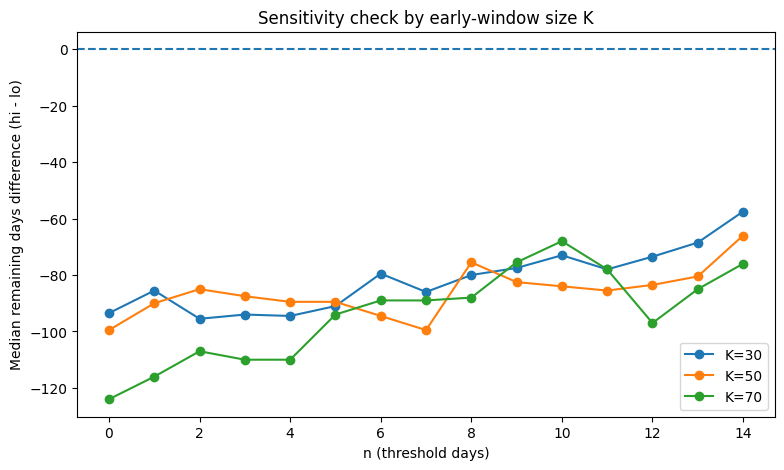

In [ ]:
def run_scan(K):
    os2 = os.sort_values(["seller_id","order_purchase_timestamp","order_id"]).copy()
    os2["order_rank"] = os2.groupby("seller_id").cumcount()+1
    early2 = os2[os2["order_rank"]<=K].copy()
    s_early = (early2.groupby("seller_id", as_index=False)
        .agg(early_orders=("order_id","nunique"),
             early_k_date=("order_purchase_timestamp","max"),
             early_max_late=("late_days","max")))
    s_early = s_early[s_early["early_orders"]==K].copy()
    s_last = (os2.groupby("seller_id", as_index=False)
        .agg(last_date=("order_purchase_timestamp","max")))
    df = s_early.merge(s_last, on="seller_id", how="left")
    df["remaining_days_after_K"] = (df["last_date"]-df["early_k_date"]).dt.days

    rows=[]
    for n in range(0,15):
        hi = df[df["early_max_late"]>n]
        lo = df[df["early_max_late"]<=n]
        rows.append({"n":n, "diff_days":hi["remaining_days_after_K"].median()-lo["remaining_days_after_K"].median()})
    return pd.DataFrame(rows)

scan10 = run_scan(30)
scan20 = run_scan(50)
scan30 = run_scan(70)

plt.figure(figsize=(9,5))
plt.plot(scan10["n"], scan10["diff_days"], marker="o", label="K=30")
plt.plot(scan20["n"], scan20["diff_days"], marker="o", label="K=50")
plt.plot(scan30["n"], scan30["diff_days"], marker="o", label="K=70")
plt.axhline(0, linestyle="--")
plt.xlabel("n (threshold days)")
plt.ylabel("Median remaining days difference (hi - lo)")
plt.title("Sensitivity check by early-window size K")
plt.legend()
plt.show()


= 3개를 같이 보는 이유:


1.   seller_kpi를 통해 전체를 보는 성적표 파악 가능 -- 어느 정도가 정상 범위인지 파악
2.   top_late 를 통해 전체 지연 물량을 줄일 타깃을 볼 수 있음
3.   top_severe를 통해 브랜드 신뢰 훼손 리스크 관리를 위해 긴급 처치 대상(?) 파악 (강한 개입 필요)

==> top_late & top_severe 겹치는 셀러가 그 중에서도 최우선 개입 대상



> churn(이탈 0/1) 대신 활동기간을 봐야 함

이유:
- Olist 공개 데이터는 **관측 기간이 끝나는 시점이 고정** 되어 있어, 마지막 구간의 셀러는 “진짜 이탈”인지 “데이터가 끝나서 안 보이는 것”인지 구분이 어려움
 => churn 라벨은 쉽게 **전부 1로 쏠리거나(정보 소실)** , 마지막 구간은 **판단 불가(검열)** 가 커짐
- 대신 `remaining_days_after_K` 같은 **활동기간 기반 지표**는 “데이터 안에서 실제로 관측되는 값”이라 비교가 안정적임

==> 질문 수정: 셀러 유지(활동 지속)에 영향을 주는 배송 지연 수준을 기반으로, 운영 개입을 시작해야 하는 경보/심각 기준일수는 무엇인가?


# 5. 중간 점검 (시각화)

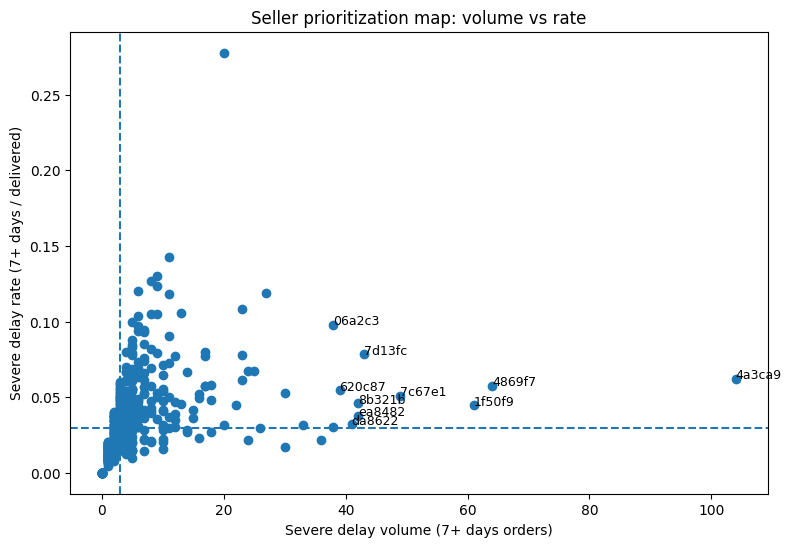

In [ ]:
df = seller_kpi_50.copy()

## 축: x=지연 물량, y=심각 지연 비율(또는 late_rate로 바꿔도 됨)
x = df["severe_7_orders"]
y = df["severe_7_rate"]

plt.figure(figsize=(9,6))
plt.scatter(x, y)

## 기준선(중앙값)으로 4분면 만들기
x_med = x.median()
y_med = y.median()
plt.axvline(x_med, linestyle="--")
plt.axhline(y_med, linestyle="--")

plt.xlabel("Severe delay volume (7+ days orders)")
plt.ylabel("Severe delay rate (7+ days / delivered)")
plt.title("Seller prioritization map: volume vs rate")

## 우선순위 TOP 라벨링(너무 많이 라벨하면 지저분하니 10개만)
top = df.sort_values(["severe_7_orders","severe_7_rate"], ascending=False).head(10)
for _, r in top.iterrows():
    plt.text(r["severe_7_orders"], r["severe_7_rate"], r["seller_id"][:6], fontsize=9)

plt.show()


ㄴ 위 이미지가 시사하는 것 = 심각 지연(7일+)은 특정 셀러에 집중되어 있음

## 중간 정리: 운영개입 우선순위 vs 임계(참는 기간) 분석의 차이
- 섹션 4~5는 “**누구를 먼저 손볼지(운영개입 우선순위)**”를 정하기 위한 셀러 KPI 중심 분석
- 섹션 6은 “셀러가 **지연을 어느 정도까지 겪으면 이후 활동이 줄어드는지(참는 기간/임계)**”를 보기 위한 분석이며,
  이를 위해 지연 노출을 **초반 K개 주문으로 고정**하여 인과 방향(원인→결과)을 더 공정하게 봄


# 6. 셀러가 며칠까지 참는가?


In [ ]:
# 6-1) 가벼운 분석용 데이터 os 만들기

os = order_seller[["seller_id","order_id","order_purchase_timestamp","late_days"]].dropna().copy()
os = os.sort_values(["seller_id","order_purchase_timestamp","order_id"])

In [ ]:
# 6-2) 초반 구간 설정 (= 첫 K개 주문 고정) + 노출 (exposure; 지연을 얼마나 겪었는지) 생성

K = 20
os["order_rank"] = os.groupby("seller_id").cumcount() + 1

early = os[os["order_rank"] <= K].copy()

seller_early = (early.groupby("seller_id", as_index=False)
    .agg(
        early_orders=("order_id","nunique"),
        early_k_date=("order_purchase_timestamp","max"),
        early_max_late=("late_days","max"),
        early_p95_late=("late_days", lambda s: np.percentile(s, 95)),
        early_severe7_rate=("late_days", lambda s: np.mean(s >= 7)),
    )
)

seller_early = seller_early[seller_early["early_orders"]==K].copy()
print("early sellers:", seller_early.shape)


early sellers: (787, 6)


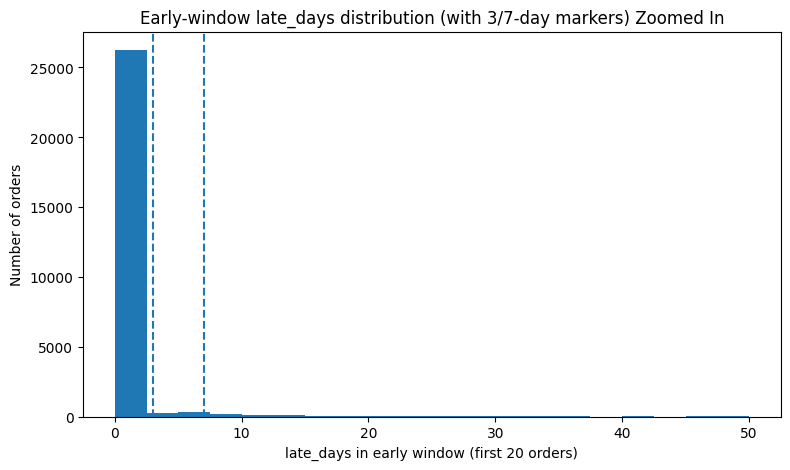

In [ ]:
# 6-2b) Early window late_days 분포 확인 (전체)

plt.figure(figsize=(9,5))
plt.hist(early["late_days"], bins=20, range=(0,50))
plt.axvline(3, linestyle="--")
plt.axvline(7, linestyle="--")
plt.xlabel("late_days in early window (first 20 orders)")
plt.ylabel("Number of orders")
plt.title("Early-window late_days distribution (with 3/7-day markers) Zoomed In")
plt.show()


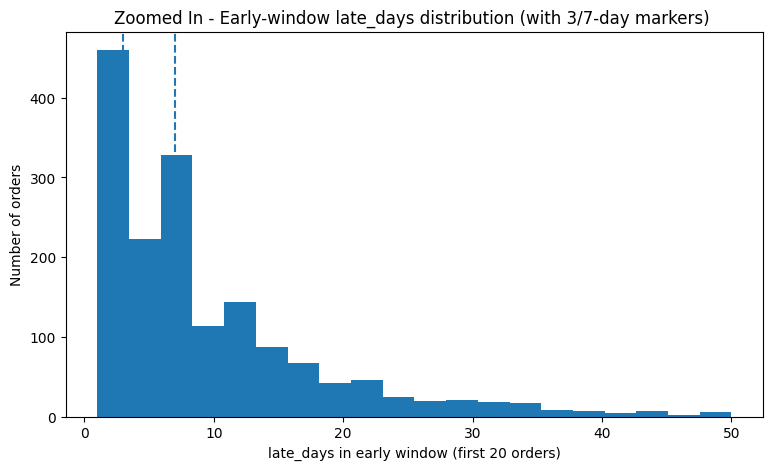

In [ ]:
# 6-2b) Early window late_days 분포 확인

plt.figure(figsize=(9,5))
plt.hist(early["late_days"], bins=20, range=(1,50))
plt.axvline(3, linestyle="--")
plt.axvline(7, linestyle="--")
plt.xlabel("late_days in early window (first 20 orders)")
plt.ylabel("Number of orders")
plt.title("Zoomed In - Early-window late_days distribution (with 3/7-day markers) ")
plt.show()



대다수의 초기 주문은 제시간에 배송되나 지연이 발생하면 짧은 지연 (3일 이내) 이 많고, 7일 이상의 심각한 지연은 드물게 발생
- 가로축: 배송이 늦어진 일수
- 세로축: 해당 지연일수에 해당하는 주문 개수

>  왜 max 기반 임계(전체 기간 중 한 번이라도 n일 초과) 대신 early window를 쓰나?
- `max_late_days > n` 같은 max 기준은 **오래 활동한 셀러일수록 한 번쯤 큰 지연을 겪을 확률이 커서**(주문 수/기간이 길수록) 분류가 왜곡될 수 있음  
  → “지연 때문에 오래/짧게 버틴다”가 아니라 “오래 버텼기 때문에 지연을 겪었을 확률이 높다”가 섞이는 문제(노출편향).
- 지연(원인)은 **초반 K개 주문**에서만 측정(early exposure)하고,
  결과는 그 이후의 **잔존 활동기간(remaining days)** 로 측정해서  
  “초반 지연 경험 → 이후 얼마나 더 버티는가”를 시간 순서대로 비교함

In [ ]:
# 6-3) 결과변수: 초반 이후 남은 활동기간 (remaining_days_after_K)

seller_last = (os.groupby("seller_id", as_index=False)
    .agg(last_date=("order_purchase_timestamp","max"),
         total_orders=("order_id","nunique"))
)

seller_df = seller_early.merge(seller_last, on="seller_id", how="left")
seller_df["remaining_days_after_K"] = (seller_df["last_date"] - seller_df["early_k_date"]).dt.days
seller_df[["early_max_late","remaining_days_after_K"]].describe()


,early_max_late,remaining_days_after_K
count,787.000000,787.000000
mean,10.254130,222.853875
std,21.186833,154.940259
min,0.000000,0.000000
25%,0.000000,101.000000
50%,4.000000,201.000000
75%,12.000000,334.500000
max,181.000000,683.000000


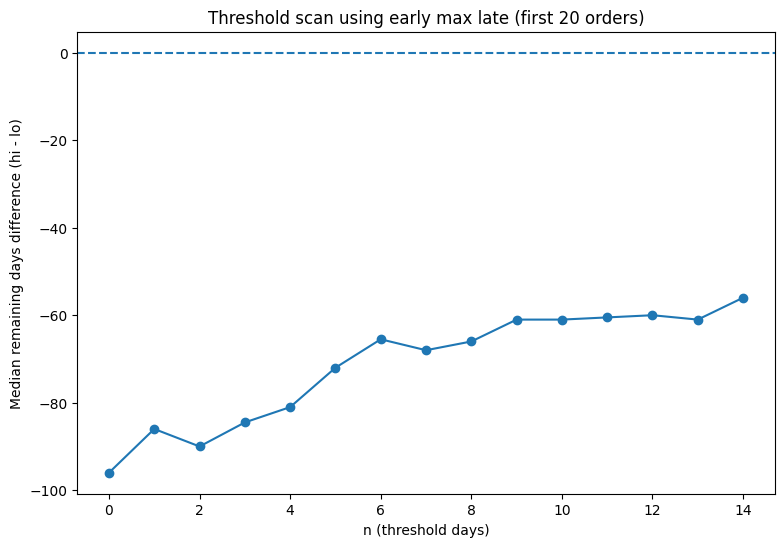

In [ ]:
# 6-4) 임계 n 스캔 + 그래프

rows=[]
for n in range(0, 15):
    hi = seller_df[seller_df["early_max_late"] > n]
    lo = seller_df[seller_df["early_max_late"] <= n]
    rows.append({
        "n": n,
        "N_hi": len(hi),
        "N_lo": len(lo),
        "diff_days": hi["remaining_days_after_K"].median() - lo["remaining_days_after_K"].median()
    })
scan2 = pd.DataFrame(rows)

plt.figure(figsize=(9,6))
plt.plot(scan2["n"], scan2["diff_days"], marker="o")
plt.axhline(0, linestyle="--")
plt.xlabel("n (threshold days)")
plt.ylabel("Median remaining days difference (hi - lo)")
plt.title(f"Threshold scan using early max late (first {K} orders)")
plt.show()


- 조금이라도 늦는 경험 자체가 셀러 활동 지속성에 매우 부정적 신호임 (n=0일 때 가장 큰 폭의 음수 값)
- 6/7일 초과지연 한 번이라도 겪으면 활동 지속 기간이 확 짧아짐

초반 지연에 따른 활동 기간 손실 (Threshold Scan) - 직관적인 이해를 위해 위의 그래프를 아래로 재시각화

초반 K개 주문에서 'n'일을 초과하는 지연을 한 번이라도 겪은 셀러가, 그렇지 않은 셀러에 비해 **활동 기간이 얼마나 줄어드는지(손실 일수)** 를 보여줌: 양수 값이 클수록 지연의 영향으로 활동 기간 손실이 크다는 의미임

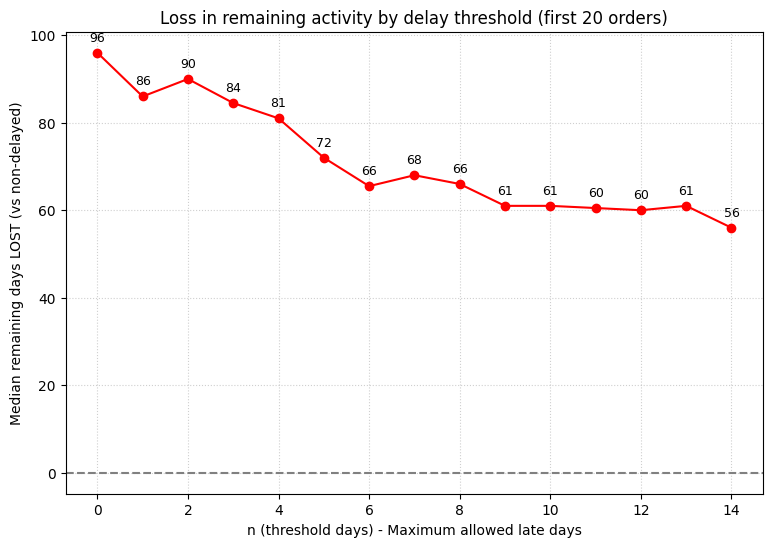

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(scan2["n"], -scan2["diff_days"], marker="o", color='red') # 음수 값을 양수로 변환하여 '손실' 강조
plt.axhline(0, linestyle="--", color='gray') # 기준선 추가

plt.xlabel("n (threshold days) - Maximum allowed late days")
plt.ylabel("Median remaining days LOST (vs non-delayed)") # 레이블 변경
plt.title(f"Loss in remaining activity by delay threshold (first {K} orders)")

# 각 점 위에 손실 일수 라벨 추가
for n_val, diff_val in zip(scan2["n"], -scan2["diff_days"]):
    plt.text(n_val, diff_val + 2, f"{diff_val:.0f}", ha='center', va='bottom', fontsize=9)

plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

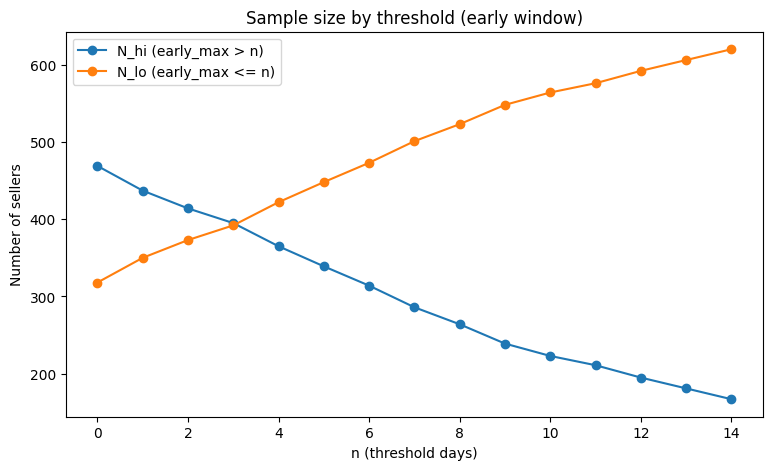

In [ ]:
# 6-4b) 임계 스캔의 표본 수 (N_hi/N_lo) 확인 -- ‘임계일’을 몇 일로 정하느냐에 따라, 관리해야 할 문제 셀러가 몇 명인지 알려주는 그래프

plt.figure(figsize=(9,5))
plt.plot(scan2["n"], scan2["N_hi"], marker="o", label="N_hi (early_max > n)")
plt.plot(scan2["n"], scan2["N_lo"], marker="o", label="N_lo (early_max <= n)")
plt.xlabel("n (threshold days)")
plt.ylabel("Number of sellers")
plt.title("Sample size by threshold (early window)")
plt.legend()
plt.show()


 ↑ '배송 지연 허용 일수(n)'를 몇 일로 정하느냐에 따라, 관리해야 할 셀러의 수가 어떻게 달라지는지 한눈에 보기

1. 축
- x축: 임계값 (0일 ~ 14일)
- y축: (임계값에 따라 문제가 있는 vs. 없는) 셀러 수


2. 선들
- 파란색 = '첫 20개 주문에서 n일보다 더 늦은 배송을 겪은 적이 있는 셀러'의 수 --> 문제 관리 대상

- 주황색 = '첫 20개 주문에서 n일 이하로만 늦은 배송을 겪은 셀러'의 수

==> 시사점

(1) 소수의 문제 셀러에게 집중할지, 넓은 범위의 셀러에게 예방 조치를 취할지 결정에 도움 될 수 있음

 (2) n=3일 정도에 문제 있다고 라벨링된 셀러 vs. 없다 라벨링된 셀러 각각 반반

# 결론
셀러는 ‘n일’ 같은 한 방 임계값이라기보다, 초반에 배송이 한 번이라도 늦기 시작하는 순간부터(>0일) 이후 활동기간이 이미 줄어들고, 6~7일 이상 지연은 “위험 구간”으로 분류하는 게 현실적으로 타당

- n=0부터 계속 음수인 이유: 초반 20건 중 n일 초과 지연을 겪은 셀러가, 안 겪은 셀러보다 이후 활동기간이 짧다는 뜻임 (=조금이라도 늦는 경험 자체가 이미 신호임)

구간:
- 1일 이상 지연부터 이미 셀러 활동 줄어드는 신호 보임
- 6~7일은 위험 레벨로 강한 개입 필요

그래도 굳이 날짜를 뽑으라고 GPT 닦달했더니...:
- 최적 임계(단일 숫자): 6일(또는 7일):“초반 20건에서 6, 7일 초과 지연을 한 번이라도 겪으면, 이후 활동 지속기간 중앙값이 약 60~70일 정도 더 짧다(그래프 수준).”
- 2단계 운영 기준(더 추천): 3일 = 경보, 7일 = 심각
-- 그래프상 0~6 구간에서 이미 큰 손상이 시작되고, 7 이후는 위험군을 더 엄격히 거르는 구간이라 “경보/심각”으로 번역이 자연스러움

= 한 줄 결론: 임계 후보는 6~7일(특히 7일이 운영적으로 가장 깔끔하긴 함)



(가능한 액션)

0~2일: 모니터링(대부분 흔한 변동)

3~6일: 경보(가벼운 개입) — 안내/확인/선제 커뮤니케이션

7일+: 심각(강한 개입) — 우선순위 올리고 즉시 에스컬레이션/패널티/보상 트리거

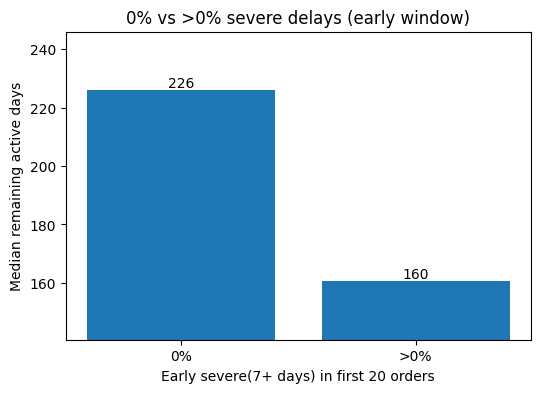

In [ ]:
# 6-5) 빈도 기반(early severe rate)으로 참는 기간 확인

## 0% vs >0% 로 단순화
seller_df["sev7_any"] = np.where(seller_df["early_severe7_rate"] == 0, "0%", ">0%")

tmp2 = (seller_df.groupby("sev7_any")["remaining_days_after_K"]
        .agg(["count", "median"])
        .reindex(["0%", ">0%"])
        .reset_index())

## y축을 좁혀서 갭 강조
ymin = tmp2["median"].min() - 20
ymax = tmp2["median"].max() + 20

plt.figure(figsize=(6,4))
bars = plt.bar(tmp2["sev7_any"], tmp2["median"])
plt.ylim(ymin, ymax)
plt.xlabel("Early severe(7+ days) in first 20 orders")
plt.ylabel("Median remaining active days")
plt.title("0% vs >0% severe delays (early window)")

## 값 라벨(간단히)
for b, v in zip(bars, tmp2["median"]):
    plt.text(b.get_x() + b.get_width()/2, v, f"{v:.0f}", ha="center", va="bottom")

plt.show()



/tmp/ipython-input-866892529.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = (seller_df.groupby("early_severe7_bin")["remaining_days_after_K"]


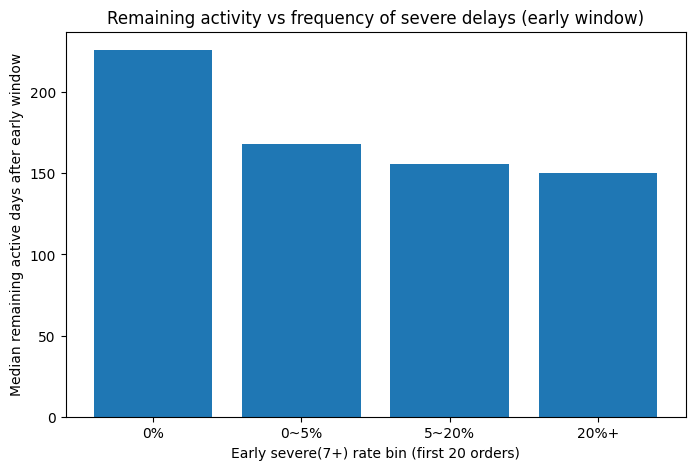

In [ ]:
seller_df["early_severe7_bin"] = pd.cut(
    seller_df["early_severe7_rate"],
    bins=[-0.001, 0, 0.05, 0.2, 1.0],
    labels=["0%", "0~5%", "5~20%", "20%+"]
)

tmp = (seller_df.groupby("early_severe7_bin")["remaining_days_after_K"]
       .median()
       .reset_index())

plt.figure(figsize=(8,5))
plt.bar(tmp["early_severe7_bin"].astype(str), tmp["remaining_days_after_K"])
plt.xlabel("Early severe(7+) rate bin (first 20 orders)")
plt.ylabel("Median remaining active days after early window")
plt.title("Remaining activity vs frequency of severe delays (early window)")
plt.show()

- 초반 20건에서 **7일+ 지연이 한 번도 없는 셀러(0%)** 는
이후에 더 오래 활동하는 경향(막대가 가장 높음)

- 반대로 초반 20건에서 **7일+ 지연이 조금이라도 반복되는 셀러(0 에서 5%, 5 에서 20%, 20%+)** 는
이후 남은 활동기간 중앙값이 더 짧아짐(막대가 내려감)

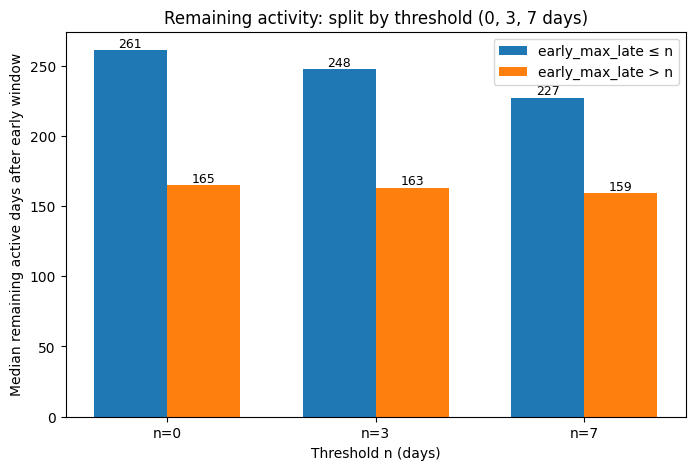

,group,count,median,threshold
1,>0d,469,165.0,0
0,≤0d,318,261.0,0
3,>3d,395,163.0,3
2,≤3d,392,247.5,3
5,>7d,286,159.0,7
4,≤7d,501,227.0,7


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 임계 후보들
thresholds = [0, 3, 7]

rows = []
for n in thresholds:
    tmp = seller_df.copy()
    tmp["group"] = np.where(tmp["early_max_late"] > n, f">{n}d", f"≤{n}d")

    agg = (tmp.groupby("group")["remaining_days_after_K"]
           .agg(["count", "median"])
           .reindex([f"≤{n}d", f">{n}d"])   # 순서 고정
           .reset_index())
    agg["threshold"] = n
    rows.append(agg)

res = pd.concat(rows, ignore_index=True)

# ----- 시각화: threshold별로 2개 막대(≤n, >n) -----
x = np.arange(len(thresholds))
w = 0.35

med_lo = [res[(res["threshold"]==n) & (res["group"]==f"≤{n}d")]["median"].iloc[0] for n in thresholds]
med_hi = [res[(res["threshold"]==n) & (res["group"]==f">{n}d")]["median"].iloc[0] for n in thresholds]

plt.figure(figsize=(8,5))
bars1 = plt.bar(x - w/2, med_lo, width=w, label="early_max_late ≤ n")
bars2 = plt.bar(x + w/2, med_hi, width=w, label="early_max_late > n")

plt.xticks(x, [f"n={n}" for n in thresholds])
plt.xlabel("Threshold n (days)")
plt.ylabel("Median remaining active days after early window")
plt.title("Remaining activity: split by threshold (0, 3, 7 days)")
plt.legend()

# 값 라벨(간단히)
for b in list(bars1) + list(bars2):
    v = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, v, f"{v:.0f}", ha="center", va="bottom", fontsize=9)

plt.show()

# (선택) 표로도 같이 보기
display(res.sort_values(["threshold","group"]))


주황색(초반에 n일 초과 지연 경험 있음) 셀러가
파란색보다 남은 활동기간 중앙값이 훨씬 짧음